In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

In [2]:
import datetime

In [3]:

def get_annee(s):
  return(s[:4])


def get_week(s):
  week=datetime.date(int(s[:4]),int(s[5:7]),int(s[8:10])).isocalendar().week
  if week>=10:

    return(s[:4]+"W"+str(week))
  
  else:
    return(s[:4]+"W0"+str(week))


In [26]:
df_temperature=pd.read_csv("/Users/corentinpla/Downloads/donnees-synop-essentielles-omm-3.csv", sep=";") #téléchargement de la table 
df_temperature=df_temperature[["Date","Température"]] #séléction de la série temporelle Température
df_temperature["Annee"]=df_temperature["Date"].apply(lambda x:get_annee(x))
df_temperature["Date"]=df_temperature["Date"].apply(lambda x: get_week(x)) #On extrait le jour de la table
df_temperature=df_temperature.groupby(["Date"]).max() #On séléctionne la température maximale relevée au cours de la journée
df_temperature=df_temperature.dropna() #on supprimme les cellules vides
df_temperature=df_temperature.sort_index() #on ordonne la table par date croissante

In [21]:
df_temperature.head()

,Température,Annee
Date,,
2022W52,284.35,2022
2022W50,283.85,2022
2022W49,288.75,2022
2022W48,287.45,2022
2022W47,289.35,2022


In [5]:
#vérification qu'on a bien 365 mesures par ans (pour la saisonalité)
for k in range (10,22):
    print("nombre mesures: pour l'année 20"+str(k))
    print(df_temperature[df_temperature["Annee"] =="20"+str(k)].shape)


nombre mesures: pour l'année 2010
(53, 2)
nombre mesures: pour l'année 2011
(52, 2)
nombre mesures: pour l'année 2012
(52, 2)
nombre mesures: pour l'année 2013
(52, 2)
nombre mesures: pour l'année 2014
(52, 2)
nombre mesures: pour l'année 2015
(53, 2)
nombre mesures: pour l'année 2016
(53, 2)
nombre mesures: pour l'année 2017
(52, 2)
nombre mesures: pour l'année 2018
(52, 2)
nombre mesures: pour l'année 2019
(52, 2)
nombre mesures: pour l'année 2020
(53, 2)
nombre mesures: pour l'année 2021
(53, 2)


In [36]:
y=df_temperature[["Température"]]

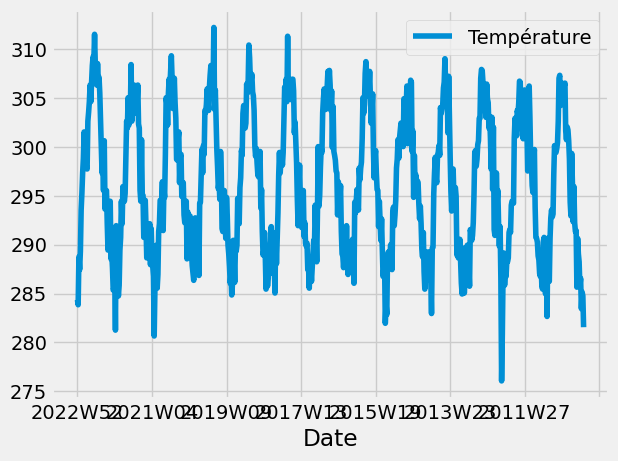

<Figure size 400x100 with 0 Axes>

In [27]:
#Temperature maximale journalière au cours du temps 
y.plot()
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(1)

plt.show()

In [41]:
df_temperature.head()

,Température,Annee
Date,,
2010W01,281.55,2010
2010W02,284.75,2010
2010W03,285.15,2010
2010W04,283.45,2010
2010W05,286.55,2010


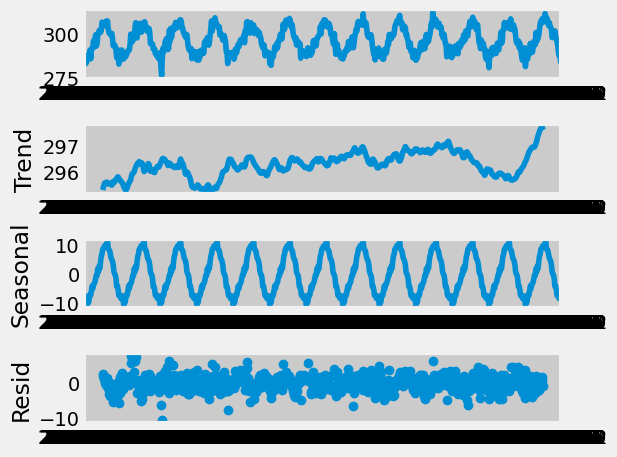

In [22]:


decomposition = sm.tsa.seasonal_decompose(y, model='additive', period= 52)
fig = decomposition.plot()
plt.show()
#Apmlitude de la composante saisonière est meilleure !

In [ ]:
#recherche des meilleurs paramètres 
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]


for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print(param,param_seasonal,results.aic)
        except: 
            continue

#minimum AIC atteint pour (1,1,1)(1,1,1,52) 


In [49]:
y_train= df_temperature[:"2019W01"]["Température"]

In [74]:

mod = sm.tsa.statespace.SARIMAX(y_train,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 53),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.91536D+00    |proj g|=  1.47973D-01


 This problem is unconstrained.



At iterate    5    f=  1.84508D+00    |proj g|=  9.30073D-02

At iterate   10    f=  1.84145D+00    |proj g|=  1.76029D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     17      1     0     0   3.806D-05   1.841D+00
  F =   1.8414518419767281     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


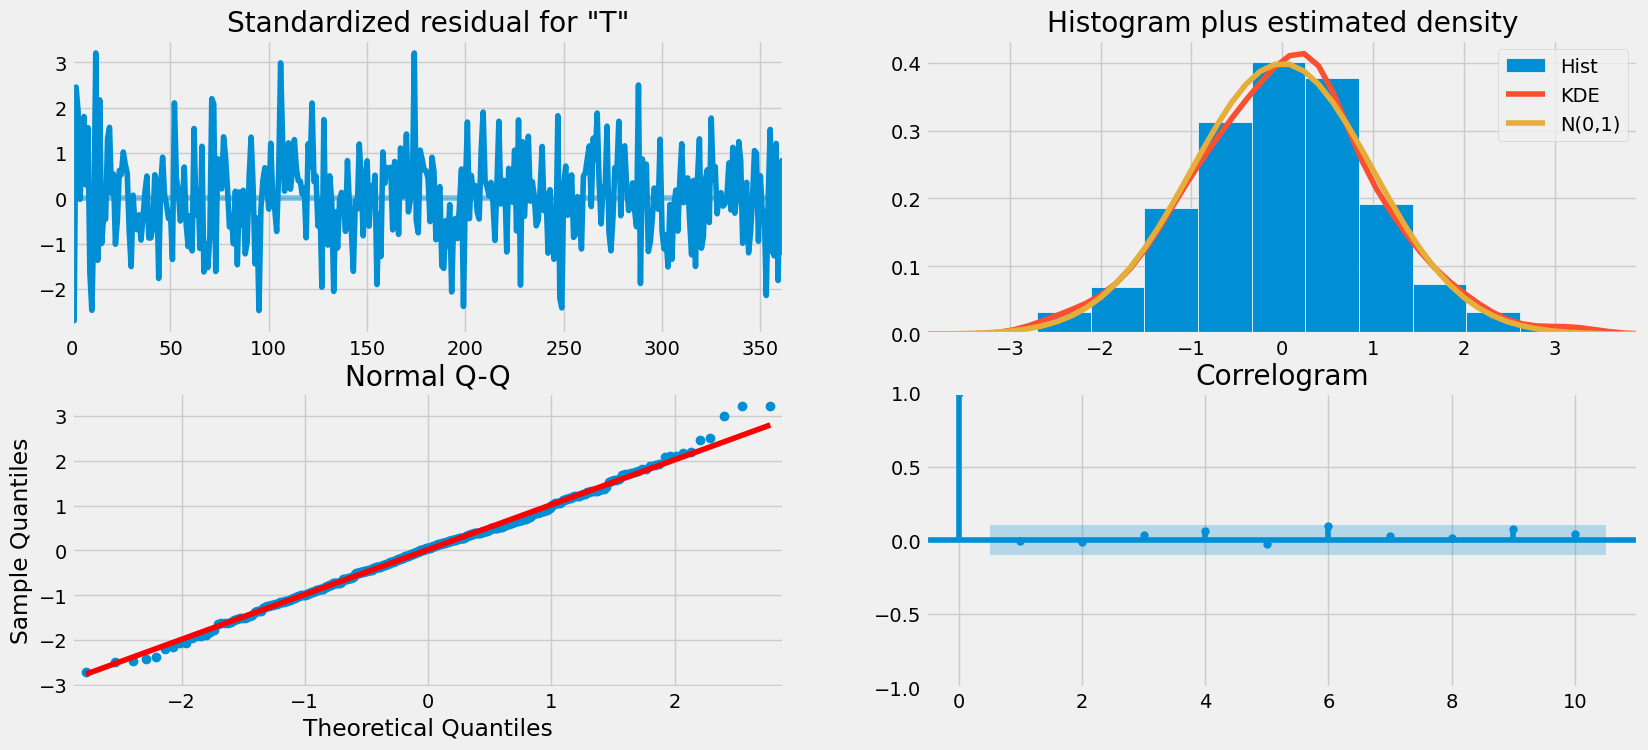

In [76]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


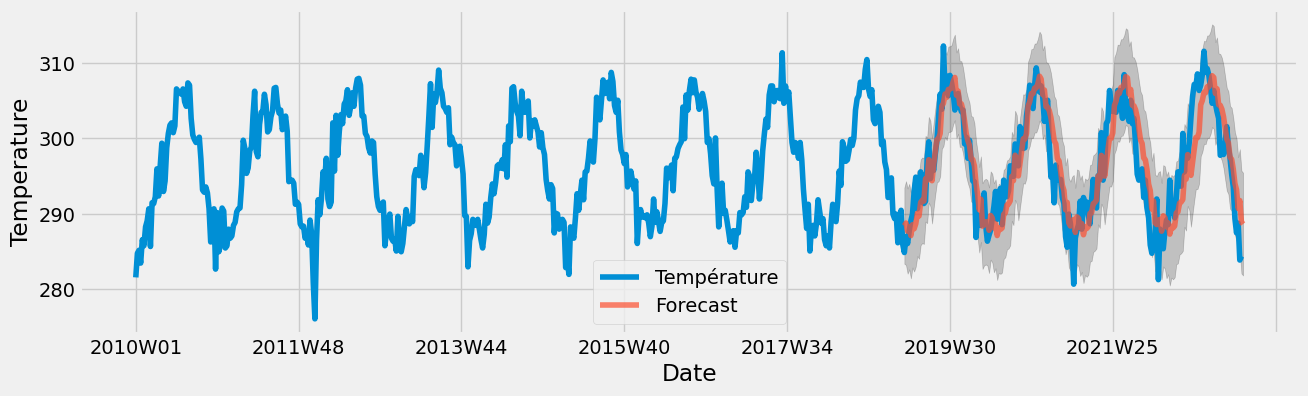

In [75]:
pred = results.get_prediction(start=472, end=df_temperature.shape[0],dynamic=False)
pred_ci = pred.conf_int()
ax = y.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
plt.legend()
plt.show()